# Connecting to Drive and Unzipping Files
---

In [1]:
import os
import zipfile

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
zip_path = '/content/drive/MyDrive/Job market analysis/archive.zip'
extract_path = '/content/drive/MyDrive/Job market analysis/Unzipped_Files'

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zipped_files:
  zipped_files.extractall(extract_path)

print(f"Extracted files to: {extract_path}")

In [5]:
all_paths = []

for root, dirs, files in os.walk(extract_path):
  for d in dirs:
    if d.endswith('.csv'):
      path = os.path.join(root, d)
      all_paths.append(path)
      print(path)

  for f in files:
    if f.endswith('.csv'):
      path = os.path.join(root, f)
      all_paths.append(path)
      print(path)

/content/drive/MyDrive/Job market analysis/Unzipped_Files/postings.csv
/content/drive/MyDrive/Job market analysis/Unzipped_Files/companies/companies.csv
/content/drive/MyDrive/Job market analysis/Unzipped_Files/companies/employee_counts.csv
/content/drive/MyDrive/Job market analysis/Unzipped_Files/companies/company_industries.csv
/content/drive/MyDrive/Job market analysis/Unzipped_Files/companies/company_specialities.csv
/content/drive/MyDrive/Job market analysis/Unzipped_Files/jobs/job_industries.csv
/content/drive/MyDrive/Job market analysis/Unzipped_Files/jobs/benefits.csv
/content/drive/MyDrive/Job market analysis/Unzipped_Files/jobs/job_skills.csv
/content/drive/MyDrive/Job market analysis/Unzipped_Files/jobs/salaries.csv
/content/drive/MyDrive/Job market analysis/Unzipped_Files/mappings/industries.csv
/content/drive/MyDrive/Job market analysis/Unzipped_Files/mappings/skills.csv


# Understanding our Data
---

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown, Image

In [7]:
# Create all necessary datframes
positions_df            = pd.read_csv(all_paths[0])
companies_df            = pd.read_csv(all_paths[1])
company_industries_df   = pd.read_csv(all_paths[3])
company_specialities_df = pd.read_csv(all_paths[4])
employee_counts_df      = pd.read_csv(all_paths[2])
benefits_df             = pd.read_csv(all_paths[6])
job_industries_df       = pd.read_csv(all_paths[5])
job_skills_df           = pd.read_csv(all_paths[7])
salaries_df             = pd.read_csv(all_paths[8])
industries_df           = pd.read_csv(all_paths[9])
skills_df               = pd.read_csv(all_paths[10])

In [32]:
def explore(title, df):
  display(Markdown(title))
  display(df.head(10))
  display(Markdown('## Descriptive Statistics'))
  display(df.describe())
  display(Markdown('## Missing Values'))
  display(df.isnull().sum().sort_values(ascending=False))
  display(Markdown('## Data Types'))
  display(df.dtypes)
  display(Markdown('## Shape'))
  display(df.shape)

# explore('# Positions Dataframe', positions_df)
# explore('# Companies Dataframe', companies_df)
# explore('# Company Industries Dataframe', company_industries_df)
# explore('# Company Specialities Dataframe', company_specialities_df)
# explore('# Employee counts Dataframe', employee_counts_df)
# explore('# Benefits Dataframe', benefits_df)
# explore('# Job Industries Dataframe', job_industries_df)
# explore('# Job Skills Dataframe', job_skills_df)
# explore('# Salaries Dataframe', salaries_df)
# explore('# Industries Dataframe', industries_df)
# explore('# Skills Dataframe', skills_df)

# Company Industries Dataframe

,company_id,industry
0,391906,Book and Periodical Publishing
1,22292832,Construction
2,20300,Banking
3,3570660,Book and Periodical Publishing
4,878353,Staffing and Recruiting
5,729238,IT Services and IT Consulting
6,766849,Staffing and Recruiting
7,12828,Food and Beverage Services
8,2934678,IT Services and IT Consulting
9,15984730,IT Services and IT Consulting


## Descriptive Statistics

,company_id
count,2.437500e+04
mean,2.038566e+07
std,3.158083e+07
min,1.009000e+03
25%,1.652215e+05
50%,2.708302e+06
75%,2.503948e+07
max,1.034730e+08


## Missing Values

,0
company_id,0
industry,0


## Data Types

,0
company_id,int64
industry,object


## Shape

(24375, 2)

### Understanding Data Notes
---
- Positions dataframe can be linked to companies datframe using company id, the latter datframe provides more information on a company such as name (some comapny name values are missing in positions datframes, they may need to be dropped), company location, size and company description. Note: Location in Positions dataframe stands for hiring locaion and not company location.
- Positions datframe can be linked to company industries dataframe using company id, it also has no missing values, it highlights what industry a job falls into e.g. company Optima Bio Supply Ltd, id no. 93223209.0 falls under the 	Medical Equipment Manufacturing industry and SynergisticIT, id no. 66321745.0 falls under IT Services and IT Consulting.
- Company specialities dataframes provides niches that companies specialize in such as SynergisticIT, id no. 66321745.0, which specializes in Software development, IT Recruitment and IT Upskill and SSi People, id no. 56833.0 that specializes in IT Staffing/Consulting, .NET, mainframe, Unix, Linux, Oracle, SQL etc. This dataframe can be used to source skills relevant to a company, industry or job title.
- Employee count dataframe provides employee count per company over time whereby the recorded employee count has a unix time as to when it was recorded.
- Benefits dataframes which contains job id contains information on benefits allocated to cerain jobs e.g. 401K, medical insurance, dental insurance etc.
- Job industries dataframe links unique job id's to industry id's differnt from company industries that shows what industry a company belongs to this can used to niche down on a specific job titles role in the indutry. It is further connected to industries dataframe that connects the unique industry Id's to their industry names.
- Positions dataframe can be linked to job skills dataframe using job id which shows what category a job falls into e.g ENG for engineering, IT for information technology and ADM for admimistration. Job id has no missing values in both positions and job skills dataframes.
- salaries dataframe provides salary data e.g. compensation tpe, currency, pay period, max and min salary values (with reletively many missing values) and a unique salary id that links to each job id.


# Data Cleaning
---

In [249]:
# drop_posistions_df_cols = [col for col in positions_df.columns
#                            if (positions_df[col].isnull().sum() / len(positions_df)) > 0.8]
# print(drop_posistions_df_cols)

['med_salary', 'applies', 'remote_allowed', 'closed_time', 'skills_desc']


In [10]:
def compare_dataframe(df_1, df_2, id_column, df_1_name, df_2_name):
  # Get a list of valid ids from df_1
  valid_ids = df_1[id_column].unique()

  # Filter df_2 rows with valid id's from df_1 to keep
  df_2_filtered = df_2[df_2[id_column].isin(valid_ids)]

  print(f"Filtered {df_2_name} dataframe successfully.")
  print(f"\nOriginal dataset shape: {df_2.shape}")
  print(f"Filtered dataset shape: {df_2_filtered.shape}")
  print(f"Percentage lost is: {(1 - (len(df_2_filtered) / len(df_2)))*100:.3f}%")
  print(f"""Missing values in company id column: {df_2_filtered[id_column].isnull().sum()}""")
  print(f"""Unique number of {id_column.strip("''")} in {df_1_name} : {df_1[id_column].nunique()}""")
  print(f"""Unique number of {id_column.strip("''")} in {df_2_name} : {df_2[id_column].nunique()}""")
  print(f"""Unique number of {id_column.strip("''")} in {df_2_name}_filtered : {df_2_filtered[id_column].nunique()}""")

  return df_2_filtered

In [11]:
display(Markdown("### Comparing unique company id's in companies_df againist all company id's in positions_df"))
print("\n")
positions_df_filtered = compare_dataframe(companies_df, positions_df, 'company_id', 'companies_df','positions_df')

# display(Markdown("### Comparing unique company id's in positions_df againist all company id's in companies_df"))
# print("\n")
# companies_df_filtered = compare_dataframe(positions_df, companies_df, 'company_id','positions_df', 'companies_df')

### Comparing unique company id's in companies_df againist all company id's in positions_df



Filtered positions_df dataframe successfully.

Original dataset shape: (123849, 31)
Filtered dataset shape: (122131, 31)
Percentage lost is: 1.387%
Missing values in company id column: 0
Unique number of company_id in companies_df : 24473
Unique number of company_id in positions_df : 24474
Unique number of company_id in positions_df_filtered : 24473


In [12]:
display(Markdown("### Comparing unique company id's in companies_df_filtered againist all company id's in company_industries_df"))
print("\n")
company_industries_df_filtered = compare_dataframe(companies_df, company_industries_df, 'company_id', 'companies_df','company_industries_df')

# display(Markdown("### Comparing unique company id's in company_industries_df againist all company id's in companies_df_filtered"))
# print("\n")
# companies_df_filtered = compare_dataframe(company_industries_df, companies_df_filtered, 'company_id','company_industries_df', 'companies_df_filtered')

### Comparing unique company id's in companies_df_filtered againist all company id's in company_industries_df



Filtered company_industries_df dataframe successfully.

Original dataset shape: (24375, 2)
Filtered dataset shape: (24375, 2)
Percentage lost is: 0.000%
Missing values in company id column: 0
Unique number of company_id in companies_df : 24473
Unique number of company_id in company_industries_df : 24365
Unique number of company_id in company_industries_df_filtered : 24365


In [13]:
display(Markdown("### Comparing unique company id's in companies_df_filtered againist all company id's in company_specialities_df"))
print("\n")
company_specialities_df_filtered = compare_dataframe(companies_df, company_specialities_df, 'company_id', 'companies_df', 'company_specialities_df')

# display(Markdown("### Comparing unique company id's in company_specialities_df againist all company id's in companies_df_filtered"))
# print("\n")
# companies_df_filtered = compare_dataframe(company_specialities_df, companies_df_filtered, 'company_id', 'company_specialities_df', 'companies_df_filtered')

### Comparing unique company id's in companies_df_filtered againist all company id's in company_specialities_df



Filtered company_specialities_df dataframe successfully.

Original dataset shape: (169387, 2)
Filtered dataset shape: (169387, 2)
Percentage lost is: 0.000%
Missing values in company id column: 0
Unique number of company_id in companies_df : 24473
Unique number of company_id in company_specialities_df : 17780
Unique number of company_id in company_specialities_df_filtered : 17780


In [14]:
display(Markdown("### Comparing unique company id's in companies_df_filtered againist all company id's in employee_counts_df"))
print("\n")
employee_counts_df_filtered = compare_dataframe(companies_df, employee_counts_df, 'company_id', 'companies_df', 'employee_counts_df')

# display(Markdown("### Comparing unique company id's in employee_counts_df againist all company id's in companies_df_filtered"))
# print("\n")
# companies_df_filtered = compare_dataframe(employee_counts_df, companies_df_filtered, 'company_id', 'employee_counts_df', 'companies_df_filtered')

### Comparing unique company id's in companies_df_filtered againist all company id's in employee_counts_df



Filtered employee_counts_df dataframe successfully.

Original dataset shape: (35787, 4)
Filtered dataset shape: (35787, 4)
Percentage lost is: 0.000%
Missing values in company id column: 0
Unique number of company_id in companies_df : 24473
Unique number of company_id in employee_counts_df : 24473
Unique number of company_id in employee_counts_df_filtered : 24473


In [230]:
# display(Markdown("### Comparing unique job id's in positions_df againist all job id's in benefits_df"))
# print("\n")
# benefits_df_filtered = compare_dataframe(positions_df, benefits_df, 'job_id', 'benefits_df')

# display(Markdown("\n### Comparing unique job id's in benefis_df againist all job id's in positions_df"))
# print("\n")
# positions_df_filtered_2 = compare_dataframe(benefits_df, positions_df, 'job_id', 'positions_df')

In [15]:
display(Markdown("### Comparing unique job id's in positions_df againist all job id's in job_industries_df"))
print("\n")
job_industries_filtered_df = compare_dataframe(positions_df_filtered, job_industries_df, 'job_id', 'positions_df_filtered', 'job_industries_df')

# display(Markdown("\n### Comparing unique job id's in job_industries_df againist all job id's in positions_df"))
# print("\n")
# positions_df_filtered = compare_dataframe(job_industries_df, positions_df_filtered, 'job_id', 'positions_df')

### Comparing unique job id's in positions_df againist all job id's in job_industries_df



Filtered job_industries_df dataframe successfully.

Original dataset shape: (164808, 2)
Filtered dataset shape: (158355, 2)
Percentage lost is: 3.915%
Missing values in company id column: 0
Unique number of job_id in positions_df_filtered : 122131
Unique number of job_id in job_industries_df : 127125
Unique number of job_id in job_industries_df_filtered : 122038


In [16]:
display(Markdown("### Comparing unique job id's in positions_df againist all job id's in job_skills_df"))
print("\n")
job_skills_filtered_df = compare_dataframe(positions_df_filtered, job_skills_df, 'job_id', 'positions_df_filtered', 'job_skills_df')

# display(Markdown("\n### Comparing unique job id's in job_skills_df againist all job id's in positions_df"))
# print("\n")
# positions_df_filtered = compare_dataframe(job_skills_df, positions_df_filtered, 'job_id', 'job_skills_df','positions_df')

### Comparing unique job id's in positions_df againist all job id's in job_skills_df



Filtered job_skills_df dataframe successfully.

Original dataset shape: (213768, 2)
Filtered dataset shape: (203167, 2)
Percentage lost is: 4.959%
Missing values in company id column: 0
Unique number of job_id in positions_df_filtered : 122131
Unique number of job_id in job_skills_df : 126807
Unique number of job_id in job_skills_df_filtered : 120590


In [17]:
display(Markdown("### Comparing unique industry id's in industries_df againist all industry id's in job_industries_df"))
print("\n")
job_industries_df_filtered_2 = compare_dataframe(industries_df, job_industries_df, 'industry_id', 'industries_df', 'job_industries_df')

display(Markdown("\n### Comparing unique industry id's in job_industries_df againist all industry id's in industries_df"))
print("\n")
industries_df_filtered_2 = compare_dataframe(job_industries_df, industries_df, 'industry_id', 'job_industries_df', 'industries_df')

### Comparing unique industry id's in industries_df againist all industry id's in job_industries_df



Filtered job_industries_df dataframe successfully.

Original dataset shape: (164808, 2)
Filtered dataset shape: (164808, 2)
Percentage lost is: 0.000%
Missing values in company id column: 0
Unique number of industry_id in industries_df : 422
Unique number of industry_id in job_industries_df : 422
Unique number of industry_id in job_industries_df_filtered : 422



### Comparing unique industry id's in job_industries_df againist all industry id's in industries_df



Filtered industries_df dataframe successfully.

Original dataset shape: (422, 2)
Filtered dataset shape: (422, 2)
Percentage lost is: 0.000%
Missing values in company id column: 0
Unique number of industry_id in job_industries_df : 422
Unique number of industry_id in industries_df : 422
Unique number of industry_id in industries_df_filtered : 422


In [18]:
display(Markdown("### Comparing unique skill abreviations in skills_df againist all skill abreviations in job_skills_df"))
print("\n")
job_skills_df_filtered_2 = compare_dataframe(skills_df, job_skills_df, 'skill_abr', 'skills_df', 'job_skills_df')

display(Markdown("\n### Comparing unique skill abreviations in job_skills_df againist all skill abreviations in skills_df"))
print("\n")
skills_df_filtered_2 = compare_dataframe(job_skills_df, skills_df, 'skill_abr', 'job_skills_df', 'skills_df')

### Comparing unique skill abreviations in skills_df againist all skill abreviations in job_skills_df



Filtered job_skills_df dataframe successfully.

Original dataset shape: (213768, 2)
Filtered dataset shape: (213768, 2)
Percentage lost is: 0.000%
Missing values in company id column: 0
Unique number of skill_abr in skills_df : 35
Unique number of skill_abr in job_skills_df : 35
Unique number of skill_abr in job_skills_df_filtered : 35



### Comparing unique skill abreviations in job_skills_df againist all skill abreviations in skills_df



Filtered skills_df dataframe successfully.

Original dataset shape: (35, 2)
Filtered dataset shape: (35, 2)
Percentage lost is: 0.000%
Missing values in company id column: 0
Unique number of skill_abr in job_skills_df : 35
Unique number of skill_abr in skills_df : 35
Unique number of skill_abr in skills_df_filtered : 35


In [19]:
# display(Markdown("### Comparing unique job ids in salaries_df againist all job id's in positions_df"))
# print("\n")
# positions_df_filtered_2 = compare_dataframe(salaries_df, positions_df, 'job_id', 'positions_df')

display(Markdown("\n### Comparing unique job id's in positions_df againist all job id's in salaries_df"))
print("\n")
salaries_df_filtered_2 = compare_dataframe(positions_df, salaries_df, 'job_id', 'positions_df', 'salaries_df')


### Comparing unique job id's in positions_df againist all job id's in salaries_df



Filtered salaries_df dataframe successfully.

Original dataset shape: (40785, 8)
Filtered dataset shape: (36073, 8)
Percentage lost is: 11.553%
Missing values in company id column: 0
Unique number of job_id in positions_df : 123849
Unique number of job_id in salaries_df : 40785
Unique number of job_id in salaries_df_filtered : 36073


### Data Cleaning Notes
---
- Comapnies df, company id will act as a primary key connecting to positions, company industries, company specialities and employee counts.
- Position df, job id will act as a primary key connecting job industries and job skills.
- Industries, industry id will act as a primary key connecting job industries.
- Skills, skill_abr will act as a primary key connecting job skills.
- 76.8% of job id's in positions df don't exist in benefits df, meaning we lack most benefits data making this dataframe potentially irrelevant for analaysis.We also have 3.8% of job id's in benefits df that don't exist in posiitons df meaning they 2 tables can't be referenced with job_id as the primary key in positions df.
- 70.9% of job id's in positions df don't exist in salaries df, meaning we lack most salaries data making this dataframe potentially irrelevant for analaysis, we also have 11.5% of job id's in salaries df that don't exist in posiitons df meaning they 2 tables can't be referenced with job_id as the primary key in positions df.

# Creating a sqlite database
---

In [11]:
!pip install eralchemy

In [20]:
import sqlite3
import csv
import eralchemy

In [21]:
conn = sqlite3.connect('linkedin_jobs.db')
cur  = conn.cursor()
cur.execute("PRAGMA foreign_keys = ON;")

In [22]:
def load_df_to_sqlite(df, table_name, schema, conn, cur):
    import numpy as np

    # Create table if it doesn't exist
    cur.execute(f"CREATE TABLE IF NOT EXISTS {table_name} {schema}")

    # Build INSERT statement
    columns = [f'"{col}"' for col in df.columns]  # Enclose column names in quotes
    placeholders = ", ".join(["?"] * len(columns))
    insert_sql = f"INSERT INTO {table_name} ({', '.join(columns)}) VALUES ({placeholders})"

    # Insert rows from DataFrame
    for _, row in df.iterrows():
        values = tuple(
            int(x) if isinstance(x, (np.int64, np.int32)) else x
            for x in (row[col.strip('"')] for col in columns)
        )
        cur.execute(insert_sql, values)

    conn.commit()


In [23]:
companies_schema = """(
  company_id INTEGER PRIMARY KEY,
  name TEXT,
  description TEXT,
  company_size REAL,
  state TEXT,
  country TEXT,
  city TEXT,
  zip_code TEXT,
  address TEXT,
  url TEXT
)"""

load_df_to_sqlite(companies_df, 'companies', companies_schema, conn, cur)

In [24]:
skills_schema = """(
  skill_abr TEXT PRIMARY KEY,
  skill_name TEXT
  )"""

load_df_to_sqlite(skills_df, 'skills', skills_schema, conn, cur)

In [25]:
industries_schema = """(
  industry_id INTEGER PRIMARY KEY,
  industry_name TEXT
  )"""

load_df_to_sqlite(industries_df, 'industries', industries_schema, conn, cur)

In [26]:
positions_schema = """(
  job_id INTEGER PRIMARY KEY,
  company_name TEXT,
  title TEXT,
  description TEXT,
  max_salary REAL,
  pay_period TEXT,
  location TEXT,
  company_id INTEGER,
  views REAL,
  med_salary REAL,
  min_salary REAL,
  formatted_work_type TEXT,
  applies REAL,
  original_listed_time REAL,
  remote_allowed REAL,
  job_posting_url TEXT,
  application_url TEXT,
  application_type TEXT,
  expiry REAL,
  closed_time REAL,
  formatted_experience_level TEXT,
  skills_desc TEXT,
  listed_time REAL,
  posting_domain TEXT,
  sponsored INTEGER,
  work_type TEXT,
  currency TEXT,
  compensation_type TEXT ,
  normalized_salary REAL,
  zip_code REAL,
  fips REAL,
  FOREIGN KEY (company_id) REFERENCES companies(company_id)
  )"""

load_df_to_sqlite(positions_df_filtered, 'positions', positions_schema, conn, cur)

In [41]:
company_industries_schema = """(
  company_id INTEGER,
  industry TEXT,
  FOREIGN KEY (company_id) REFERENCES companies(company_id)
  )"""

load_df_to_sqlite(company_industries_df_filtered, 'company_industries', company_industries_schema, conn, cur)

In [44]:
company_specialities_schema = """(
  company_id INTEGER,
  speciality TEXT,
  FOREIGN KEY (company_id) REFERENCES companies(company_id)
  )"""

load_df_to_sqlite(company_specialities_df_filtered, 'company_specialities', company_specialities_schema, conn, cur)

In [31]:
employee_counts_schema = """(
  company_id INTEGER,
  employee_count INTEGER,
  follower_count INTEGER,
  time_recorded INTEGER,
  FOREIGN KEY (company_id) REFERENCES companies(company_id)
  )"""

load_df_to_sqlite(employee_counts_df, 'employee_count', employee_counts_schema, conn, cur)

In [46]:
job_skills_schema = """(
  job_id INTEGER,
  skill_abr TEXT,
  FOREIGN KEY (job_id) REFERENCES positions(job_id),
  FOREIGN KEY (skill_abr) REFERENCES skills(skill_abr)
  )"""

load_df_to_sqlite(job_skills_filtered_df, 'job_skills', job_skills_schema, conn, cur)

In [49]:
job_industries_schema = """(
  job_id INTEGER,
  industry_id INTEGER,
  FOREIGN KEY (job_id) REFERENCES positions(job_id),
  FOREIGN KEY (industry_id) REFERENCES industries(industry_id)
  )"""

load_df_to_sqlite(job_industries_filtered_df, 'job_industries', job_industries_schema, conn, cur)

In [50]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

[('companies',), ('skills',), ('industries',), ('positions',), ('employee_count',), ('company_industries',), ('company_specialities',), ('job_skills',), ('job_industries',)]


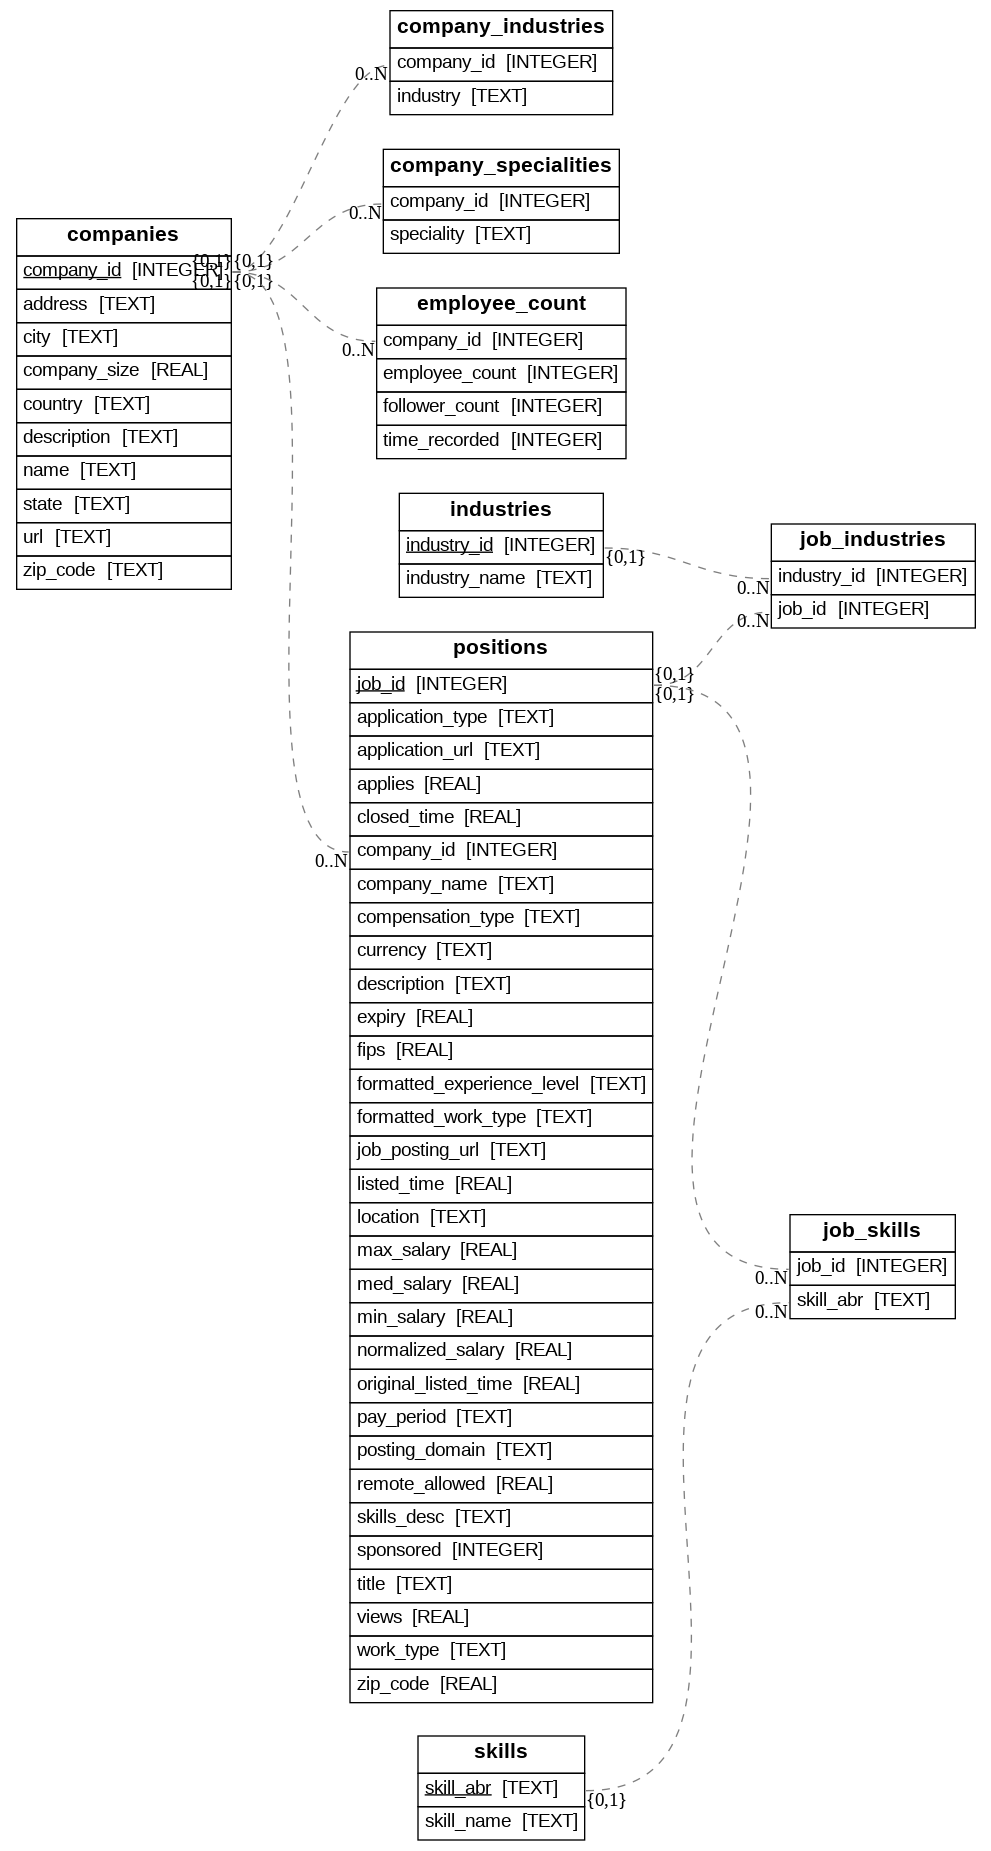

In [51]:
!cp linkedin_jobs.db tmp_linkedin_jobs.db
!eralchemy -i sqlite:///tmp_linkedin_jobs.db -o linkedin_jobs_erd.dot
!dot -Tpng linkedin_jobs_erd.dot -o linkedin_jobs_erd.png
Image(filename='/content/linkedin_jobs_erd.png')